In [3]:
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger

import pickle
import json
import pandas as pd
import re
from pathlib import Path

data_dir = Path(globals()['_dh'][0]).parent / 'data'
figure_dir = data_dir / 'figures'
figure_dir.mkdir(exist_ok=True)

plt.style.use('seaborn-bright')
plt.set_cmap('plasma')

<Figure size 432x288 with 0 Axes>

In [26]:
def parse_ping_result(string):
    """make regex with named groups"""
    regex = r'rtt min/avg/max/mdev = (?P<min>\d+\.\d+)/(?P<avg>\d+\.\d+)/(?P<max>\d+\.\d+)/(?P<mdev>\d+\.\d+) ms'
    m = re.search(regex, string)
    return dict(min=float(m.group('min')), avg=float(m.group('avg')), max=float(m.group('max')), mdev=float(m.group('mdev')))

with (data_dir / "latency.json").open('r') as f:
    df = pd.DataFrame(json.load(f))
df = df.set_index(['src', 'dst'])
df

ping_str  \
src                dst                                                                      
aws:us-west-2      gcp:us-east1-b       rtt min/avg/max/mdev = 82.863/83.117/84.051/0....   
                   aws:us-west-1        rtt min/avg/max/mdev = 20.449/20.616/21.064/0....   
                   aws:us-east-2        rtt min/avg/max/mdev = 54.206/54.230/54.304/0....   
                   aws:ap-northeast-1   rtt min/avg/max/mdev = 98.398/98.424/98.540/0....   
aws:us-west-1      gcp:us-west1-a       rtt min/avg/max/mdev = 21.817/22.171/23.075/0....   
...                                                                                   ...   
gcp:europe-west1-b aws:ap-southeast-1   rtt min/avg/max/mdev = 169.133/169.278/169.716...   
                   gcp:asia-east2-a     rtt min/avg/max/mdev = 145.050/145.806/150.910...   
                   gcp:us-central1-a    rtt min/avg/max/mdev = 48.789/105.043/312.888/...   
                   aws:eu-central-1     rtt min/avg/max/mdev = 150.326/150.482/150.999...   
                   gcp:europe-north1-a  rtt min/avg/max/mdev = 183.715/183.861/184.106...   

                                            min      avg      max    mdev  
src                dst                                                     
aws:us-west-2      gcp:us-east1-b        82.863   83.117   84.051   0.395  
                   aws:us-west-1         20.449   20.616   21.064   0.254  
                   aws:us-east-2         54.206   54.230   54.304   0.296  
                   aws:ap-northeast-1    98.398   98.424   98.540   0.246  
aws:us-west-1      gcp:us-west1-a        21.817   22.171   23.075   0.403  
...                                         ...      ...      ...     ...  
gcp:europe-west1-b aws:ap-southeast-1   169.133  169.278  169.716   0.372  
                   gcp:asia-east2-a     145.050  145.806  150.910   1.749  
                   gcp:us-central1-a     48.789  105.043  312.888  98.676  
                   aws:eu-central-1     150.326  150.482  150.999   0.363  
                   gcp:europe-north1-a  183.715  183.861  184.106   0.352  

[240 rows x 5 columns]

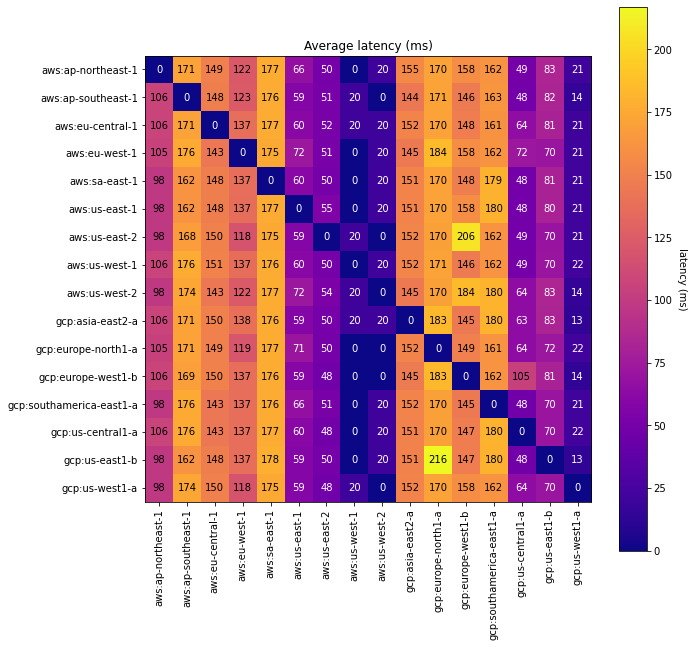

In [47]:
regions = list(sorted(df.index.get_level_values(0).unique()))
avg_latencies = np.zeros((len(regions), len(regions)))
for i, src_region in enumerate(regions):
    for j, dst_region in enumerate(regions):
        if src_region != dst_region:
            row = df.loc[(src_region, dst_region)]
            avg_latencies[i, j] = row['avg']
            # avg_latencies[j, i] = row['mdev']

# plot min, avg, max, mdev
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(avg_latencies)
ax.set_title('Average latency (ms)')

# show colorbar
cbar = ax.figure.colorbar(ax.images[0], ax=ax)
cbar.ax.set_ylabel('latency (ms)', rotation=-90, va='bottom')

# add labels to axes with region names
ax.set_xticks(np.arange(len(regions)))
ax.set_yticks(np.arange(len(regions)))
ax.set_xticklabels(regions)
ax.set_yticklabels(regions)

# rotate x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# label each point with rounded average latency, invert text color for dark background
for i, row in enumerate(avg_latencies):
    for j, col in enumerate(row):
        ax.text(j, i, int(col), ha='center', va='center', color='white' if avg_latencies[i, j] < avg_latencies.mean() else 'black')

# set white background
fig.patch.set_facecolor('white')

plt.show()
fig.savefig(figure_dir / 'latency_avg.png', dpi=300, bbox_inches='tight')
fig.savefig(figure_dir / 'latency_avg.pdf', bbox_inches='tight')
